# Letters
## Description
Generate an image with the edges of the letters present in this noisy image
## Group 5
- Francisco Macedo Ferreira PG55942
- Júlio José Medeiros Pereira Pinto PG57883
- Ivan Sérgio Rocha Ribeiro PG55950

## How the Projects Works

> This project is divided into three main parts:
> 
> - Operations
> - Helper Functions
> - Main Function
> 
> **Operations** is where the core functionalities reside. Essentially, every applicable effect (along with its code) can be found here.
> 
> **Helper Functions**, as the name suggests, are functions used throughout the code (e.g., loading images, creating plots, etc.).
> 
> **Main Function** consists of the cells that tie everything together. In this part, we can define pipelines, which specify the effects applied to the image in a sequential order.
> 
> We decided to implement these pipelines for image processing as a way to test different combinations and optimize our time. With further development, this program could evolve into a robust tool, allowing us to combine different pipelines, explore their outputs, and fine-tune the values within each pipeline.


Nonetheless, in the following Notebook we talk about each operation and how it helped us as well as an overall review of what we think was the better outcome we could achieve.


# Imports and Global Variables

In [ ]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np

fname = 'Letters-noisy.png'
operations = {}
pipeline_order = []
masks = []
notch_filters = []

# Operations

### IDFT

This process represents the Inverse Discrete Fourier Transform (IDFT) transformation, which converts the image from the frequency domain back to the spatial domain. 

In [957]:
def compute_idft(dft):
    dft = np.fft.ifftshift(dft)
    img_back = cv2.idft(dft)
    magnitude = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    
    # Normalize and convert to uint8
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    return magnitude.astype(np.uint8)

operations['idft'] = compute_idft
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>}


### DTF

This process represents the Discrete Fourier Transform (DFT) transformation, which converts the image from the spatial domain to the frequency domain.

In [958]:
def compute_dft(img):
    # Convert image to float32 if needed
    if img.dtype != np.float32:
        img = np.float32(img)
    
    dft = cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)
    return np.fft.fftshift(dft)

operations['dft'] = compute_dft
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>}


### Inpaint (Black and White)

To address the salt-and-pepper noise in our image, we initially explored inpainting as a potential solution. By creating a mask to detect extreme pixel values (0 and 255) and applying the Telea inpainting algorithm, we aimed to selectively fill in noisy areas using information from surrounding pixels. This approach preserved details better than traditional blurring techniques, preventing excessive smoothing. However, while inpainting effectively handled isolated noise and small artifacts, we found that a median filter provided a more consistent and efficient solution for removing the salt-and-pepper effect. Nevertheless, inpainting proved useful in other situations, such as restoring missing details and repairing small damaged regions in the image.

This function was later used to fill larger regions where pixels had been removed, such as areas affected by the application of threshold masks.

In [959]:
# Inpainting
def inpaint_image(img):
    mask = (img == 0) | (img == 255)
    mask = mask.astype(np.uint8) * 255
    
    return cv2.inpaint(img, mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

operations['inpaint'] = inpaint_image
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>}


### Paint

This function applies a certain color to the negative regions in a mask.

In [960]:
def paint_image_mask(img):
    # Apply a mask and paint where its black in the mask
    if masks:
        mask = masks[1]
        img[mask == 0] = 128
        
    return img
    
operations['paint'] = paint_image_mask
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>}


### Invert Bitwise

Very much like the name indicates, this function only serves to invert our image bitwise.

In [961]:
def apply_invert(img):
    return cv2.bitwise_not(img)

operations['invert'] = apply_invert

### Binarization

Very much like the name indicates, this function only serves to binarize our image.

In [ ]:
def binarize_pixels(image_array):
    if image_array.dtype != np.uint8:
        image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    threshold_value = 162  # Adjust this value based on your needs
    _, binarized_image = cv2.threshold(image_array, threshold_value, 255, cv2.THRESH_BINARY)
    
    return binarized_image

operations['binarize'] = binarize_pixels
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>}


### Threshold Filter

To create an effective mask for cleaning up the word, we decided to use thresholding. We experimented with various methods, including Global Thresholding, Adaptive Thresholding, and Otsu's Thresholding. During our tests, we observed that directly applying these techniques sometimes led to suboptimal results. Ultimately, we found that inverting the image bitwise before applying thresholding consistently produced cleaner and more accurate masks, improving the overall effectiveness of the process.

In [ ]:
def apply_thresholding(img, plots=False, inpaint=True):
    if img.max() > 1.0:
        img = img / 255.0

    img_uint8 = (img * 255).astype(np.uint8)
    
    inverted_img = cv2.bitwise_not(img_uint8)  # Now it's uint8

    hist_float = np.histogram(img, bins=256, range=(0,1))[0]

    # Apply different thresholding methods
    _, Gthres = cv2.threshold(inverted_img.astype(np.float32) / 255.0, 0.2, 1.0, cv2.THRESH_BINARY)

    # Otsu's method requires uint8 input
    _, Othres = cv2.threshold(inverted_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    Othres = Othres.astype(np.float32) / 255.0  # Normalize back

    # Adaptive thresholding also needs uint8
    Athres = cv2.adaptiveThreshold(inverted_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 1)
    Athres = Athres.astype(np.float32) / 255.0

    masks.clear()
    masks.append(Gthres)
    masks.append(Othres)
    masks.append(Athres)

    if plots:
        fig, axs = plt.subplots(3, 2, figsize=(12, 24))
        axs[0, 0].imshow(img, cmap='gray')
        axs[0, 0].set_title('Original')
        axs[0, 0].axis('off')

        axs[0, 1].plot(hist_float)
        axs[0, 1].set_title('Histogram')
        axs[0, 1].axis('off')

        axs[1, 0].imshow(Gthres, cmap='gray')
        axs[1, 0].set_title('Global Thresholding')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(Othres, cmap='gray')
        axs[1, 1].set_title('Otsu Thresholding')
        axs[1, 1].axis('off')

        axs[2, 0].imshow(Athres, cmap='gray')
        axs[2, 0].set_title('Adaptive Thresholding')
        axs[2, 0].axis('off')

        plt.show()

    # Invert the Otsu threshold mask before applying it
    inverted_mask = cv2.bitwise_not((Othres * 255).astype(np.uint8))

    result = apply_mask(img_uint8, inverted_mask, True, inpaint)

    return result

def apply_thresholding_noinpaint(img):
    return apply_thresholding(img, plots=True, inpaint=False)

operations['thresholding_inpaint'] = apply_thresholding
operations['thresholding'] = apply_thresholding_noinpaint


### Median Blur

Firstly, we decided to use the function `inpaint` in order to remove the salt and pepper effect. After some testing and messing around we realized we were over complicating it so we decided to change it to use a Median Blur approach, which aligns much better with what was taught in class.

In [964]:
def apply_median_filter(img):
    return cv2.medianBlur(img, 5)

operations['median'] = apply_median_filter
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>}


### Gaussian Blurs

For our approach, we chose to apply Gaussian blur to selectively soften either the image or the negative region of a mask. This technique provided us with greater flexibility, allowing us to experiment with different strategies, particularly when combined with other filters. The ability to create and manipulate masks through these combined effects proved invaluable in fine-tuning our results and achieving more precise control over the image processing.

In [ ]:

def apply_gaussian_blur(img):
        
    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)
    
    result_img = img.copy()
    
    if(masks.__len__() > 1): 
        result_img[masks[1] == 0] = blurred_img[masks[1] == 0]
    else:
        result_img = blurred_img

    return result_img

operations['gaussian'] = apply_gaussian_blur
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>}


### Sobel Magnitude

We used the Sobel Magnitude method to enhance the edges of our word, but it didn't produce the expected outcome. Instead of highlighting the word's edges clearly, it captured the edges of the surrounding "noise," making it difficult to discern the word itself. This approach didn't provide the clarity we were aiming for in extracting the word’s structure.

In [ ]:
def sobel_mag(img):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    image = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return image

operations['sobel'] = sobel_mag
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>}


### Bilateral Filter

We use a bilateral filter to reduce noise while preserving edges. Unlike traditional smoothing filters, it considers both spatial distance and pixel intensity differences, ensuring that edges remain sharp while homogeneous areas are smoothed. This makes it highly effective for denoising our grayscale image without blurring important details.

In [ ]:
def apply_bilateral_filter(image):
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.bilateralFilter(image, d=15, sigmaColor=90, sigmaSpace=90)

operations['bilateral'] = apply_bilateral_filter
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>}


### CLAHE

We use CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance contrast effectively. CLAHE boosts local contrast while preventing over-amplification of noise by limiting the contrast enhancement in homogeneous regions. This ensures fine details are preserved and improves visibility in both bright and dark areas, making it more effective for our grayscale image. Unlike standard histogram equalization, CLAHE operates on small regions (tiles) of the image, equalizing them independently before blending to remove artificial boundaries.

After many tests, combining this filter with the use of a bilateral filter, we believe this was the best approach to have greater contrast in our image and make the word pop more.

In [ ]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    processed_image = clahe.apply(image)
    
    return processed_image

operations['clahe'] = apply_clahe
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>, 'clahe': <function apply_clahe at 0x7d62b5182c00>}


### Canny Edges

We tried to use the Canny Edges algorithm to be able to manage to get the edges of the letters, but ended up not managing with this approach.


In [969]:
def apply_canny_edges(img):
    np.bitwise_not(img)
    edges = cv2.Canny(img,100,200)
    
    return edges

operations['canny'] = apply_canny_edges

### Gamma Correction

Since Gamma Correction tens to help pop out more the whites, we decided to use to do the inverse. By using `bitwise_not` we manage to change the whites to black and vice-versa and then use the Gamma Correction filter properly, at the end we end up using `bitwise_not` to reverse the image once more and get "fuller" grays and blacks.

In [ ]:
def gammaCorrection(src):
    invGamma = 1 / 2.2
    
    src = np.bitwise_not(src)

    src_uint8 = (src * 255).clip(0, 255).astype(np.uint8) if src.dtype != np.uint8 else src

    table = np.array([((i / 255) ** invGamma) * 255 for i in range(256)], dtype=np.uint8)

    corrected_uint8 = cv2.LUT(src_uint8, table)
    
    img = np.bitwise_not(corrected_uint8)

    return img

operations['gamma'] = gammaCorrection


### Sharpen


In [ ]:
def sharpen(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ], dtype=np.float32)
    
    sharpened_image = cv2.filter2D(image, -1, kernel)
    
    return np.clip(sharpened_image, 0, 255).astype(np.uint8)

operations['sharpen'] = sharpen

## Frequency Filters

### Low-Pass Frequency Filter

We initially tested both circular and rectangular center shapes for our filter, but neither impacted the image as strongly as we had hoped. Ultimately, we shifted our approach from a notch-like low-pass filter to a Butterworth low-pass filter, which provided a smoother, more linear frequency response. This change proved particularly effective when combined with notch filters, as it helped eliminate the 'checkerboard' pattern visible in the original image.

In [ ]:
def apply_low_pass_filter(dft, order=2, cutoff=30):
    if dft.dtype != np.float32:
        dft = np.float32(dft)
    
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    u = np.arange(rows) - crow
    v = np.arange(cols) - ccol
    U, V = np.meshgrid(v, u)
    
    D = np.sqrt(U**2 + V**2)
    
    # Butterworth low-pass filter
    H = 1 / (1 + (D / cutoff)**(2*order))
    
    mask = np.stack([H, H], axis=2).astype(np.float32)
    
    return (dft * mask).astype(np.float32)

operations['low_pass'] = apply_low_pass_filter
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>, 'clahe': <function apply_clahe at 0x7d62b5182c00>, 'canny': <function apply_canny_edges at 0x7d62e3dab100>, 'gamma': <function gammaCorrection at 0x7d62e3da8680>, 'sharpen': <function sharpen at 0x7d62e29b2fc0>, 'low_pass': <function apply_low_pass_filter at 0x7d62e37b3100>}


### High-Pass Frequency Filter

To enhance the gray and black colors further, we experimented with a Butterworth high-pass filter, aiming for a smoother and more linear application compared to other methods. However, this approach ultimately proved ineffective; it reduced the image’s readability when initially applied and, in the end, only slightly emphasized the outlines of those colors.

In [ ]:
def apply_high_pass_filter(dft, order=2, cutoff=60):
    if dft.dtype != np.float32:
        dft = np.float32(dft)
        
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    
    u = np.arange(rows) - crow
    v = np.arange(cols) - ccol
    U, V = np.meshgrid(v, u)
    
    D = np.sqrt(U**2 + V**2)
    
    # Butterworth high-pass filter with increased cutoff
    H = 1 / (1 + (cutoff / (D + 1e-6))**(2*order))
    
    mask = np.stack([H, H], axis=2).astype(np.float32)
    
    return (dft * mask).astype(np.float32)

operations['high_pass'] = apply_high_pass_filter
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>, 'clahe': <function apply_clahe at 0x7d62b5182c00>, 'canny': <function apply_canny_edges at 0x7d62e3dab100>, 'gamma': <function gammaCorrection at 0x7d62e3da8680>, 'sharpen': <function sharpen at 0x7d62e29b2fc0>, 'low_pass': <function apply_low_pass_filter at 0x7d62e37b3100>, 'high_pass': <fu

### Unsharp Mask

We decided to try and use an Unsharp Mask as an alternative to a Low or High Pass Filter, but the results weren't satisfatory. 


In [974]:
def apply_unsharp_mask(dft, sigma=1.0, strength=1.5):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2

    mask = np.ones((rows, cols, 2), np.float32) 
    
    cv2.circle(mask, (ccol, crow), int(sigma * min(rows, cols)), (1 + strength, 1 + strength), -1)

    sharpened_dft = dft * mask

    return sharpened_dft

operations['unsharp'] = apply_unsharp_mask
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>, 'clahe': <function apply_clahe at 0x7d62b5182c00>, 'canny': <function apply_canny_edges at 0x7d62e3dab100>, 'gamma': <function gammaCorrection at 0x7d62e3da8680>, 'sharpen': <function sharpen at 0x7d62e29b2fc0>, 'low_pass': <function apply_low_pass_filter at 0x7d62e37b3100>, 'high_pass': <fu

## Notch Filters

### Regular Notch Filter

This approach proved to be one of the most effective in reducing the "checkerboard" effect. By analyzing the Fourier transform of the image and strategically applying different notches, we were able to eliminate high-frequency spikes. As a result, we achieved a much clearer and more refined outcome in minimizing the unwanted pattern.

We implemented different notches lists in order to test different approaches when removing high-frequency spikes.

In [975]:



# Apply Notch Filter
def apply_notch_filter(dft, i):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    notch_centers = [[ (ccol - 30, crow + 20, 10), (ccol + 30, crow - 20, 10), (ccol + 30, crow + 20, 10), (ccol - 30, crow - 20, 10),
                   (ccol + 20, crow, 5), (ccol - 20, crow, 5), (ccol - 5, crow + 10, 5), (ccol + 5, crow - 10, 5)
                 ],
                 [ (ccol - 30, crow + 20, 10), (ccol + 30, crow - 20, 10),
                  (ccol + 20, crow, 5), (ccol - 20, crow, 5), (ccol - 5, crow + 10, 5), (ccol + 5, crow - 10, 5)
                 ],
                 [ (ccol + 30, crow + 20, 10), (ccol - 30, crow - 20, 10), (ccol + 15, crow - 15, 5), (ccol - 15, crow + 15, 5)]
                ]

    center = notch_centers[i]
    
    mask = np.ones((rows, cols, 2), np.uint8)
    for x, y, r in center:
        cv2.circle(mask, (x, y), r, (0, 0), -1)
    
    return dft * mask

def apply_notch0(dft):
    return apply_notch_filter(dft, 0)

def apply_notch1(dft):
    return apply_notch_filter(dft, 1)

def apply_notch2(dft):
    return apply_notch_filter(dft, 2)

operations['notch0'] = apply_notch0
operations['notch1'] = apply_notch1
operations['notch2'] = apply_notch2
print(operations)


{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>, 'clahe': <function apply_clahe at 0x7d62b5182c00>, 'canny': <function apply_canny_edges at 0x7d62e3dab100>, 'gamma': <function gammaCorrection at 0x7d62e3da8680>, 'sharpen': <function sharpen at 0x7d62e29b2fc0>, 'low_pass': <function apply_low_pass_filter at 0x7d62e37b3100>, 'high_pass': <fu

### Donut Notch Filter

To try different results, we tried with different shapes the usage of a notch filter. We called this one the donut, since the middle is hollow and resembles a ring/donut.
For the first few tests, allowed us to achieve better results, but after refining the regular notch filter implementation it proved to be unnencessary.


In [976]:
# Apply Donut Notch Filter
def apply_donut_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    notch_centers = [(ccol - 30, crow - 20, 10, 30), (ccol + 30, crow + 20, 10, 30)]
    
    mask = np.ones((rows, cols, 2), np.uint8)
    
    for x, y, r_inner, r_outer in notch_centers:
        cv2.circle(mask, (x, y), r_outer, (0, 0), -1)
        cv2.circle(mask, (x, y), r_inner, (1, 1), -1)
    return dft * mask

operations['donut'] = apply_donut_notch_filter
print(operations)


{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>, 'clahe': <function apply_clahe at 0x7d62b5182c00>, 'canny': <function apply_canny_edges at 0x7d62e3dab100>, 'gamma': <function gammaCorrection at 0x7d62e3da8680>, 'sharpen': <function sharpen at 0x7d62e29b2fc0>, 'low_pass': <function apply_low_pass_filter at 0x7d62e37b3100>, 'high_pass': <fu

### Inverted Notch Filter

This implementation is similar to the Low-Pass filter but provides more flexibility for testing. When we tested it using the standard notch_centers array from the Notch Center Function, the results were unsatisfactory. Nonetheless this allows us to use a simpler version of the Low-Pass filter (without Buttersworth effect).

In [977]:

# Apply Inversed Notch Filter
def apply_inversed_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    notch_centers = [(ccol, crow, 50)]

    mask = np.zeros((rows, cols, 2), np.uint8)
    for x, y, r in notch_centers:
        cv2.circle(mask, (x, y), r, (1, 1), -1)
    return dft * mask

operations['inversed_notch'] = apply_inversed_notch_filter
print(operations)

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>, 'clahe': <function apply_clahe at 0x7d62b5182c00>, 'canny': <function apply_canny_edges at 0x7d62e3dab100>, 'gamma': <function gammaCorrection at 0x7d62e3da8680>, 'sharpen': <function sharpen at 0x7d62e29b2fc0>, 'low_pass': <function apply_low_pass_filter at 0x7d62e37b3100>, 'high_pass': <fu

# Helper Functions


### Load Image & Analyzing

The first few steps that allow us to better understande the image and afterwards load it.


{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>, 'clahe': <function apply_clahe at 0x7d62b5182c00>, 'canny': <function apply_canny_edges at 0x7d62e3dab100>, 'gamma': <function gammaCorrection at 0x7d62e3da8680>, 'sharpen': <function sharpen at 0x7d62e29b2fc0>, 'low_pass': <function apply_low_pass_filter at 0x7d62e37b3100>, 'high_pass': <fu

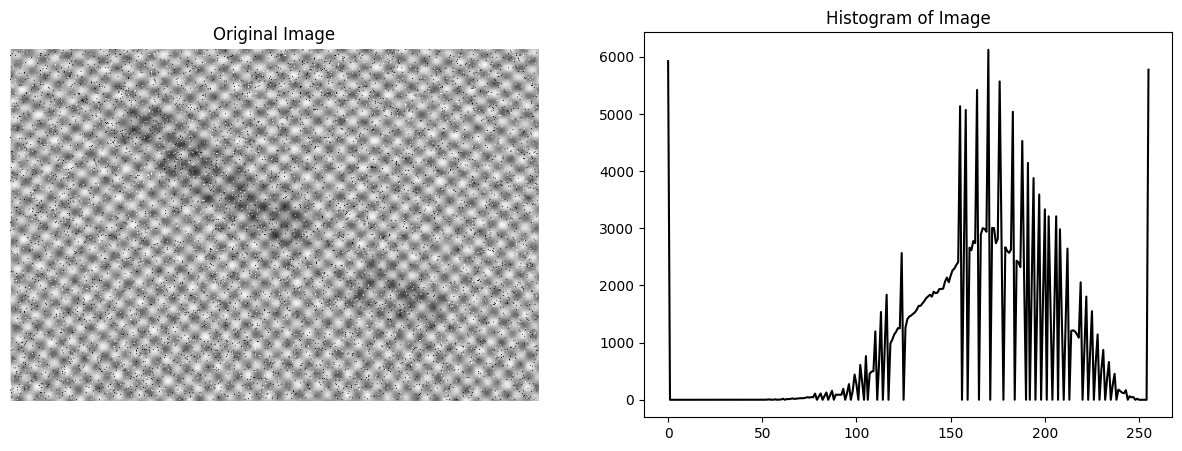

In [978]:

def analyze_image(img):
    hist = cv2.calcHist([img.astype(np.uint8)], [0], None, [256], [0, 256])
    return hist

def apply_analyze_image(img):
    hist = analyze_image(img)
    # Just the histogram
    plt.plot(hist, color='black')
    plt.title('Histogram of Image')
    plt.show()

    return img

operations['analyze'] = apply_analyze_image
print(operations)


def load_image(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    hist = analyze_image(img)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].plot(hist, color='black')
    axes[1].set_title('Histogram of Image')
    plt.show()

    return np.float32(img)

data = load_image(fname)
original = data.copy()

### Plots

A generic plot function to show data.


In [979]:
def plot_result(data, title):
    if data.ndim == 2:  # Spatial domain
        plt.figure()
        plt.title(title)
        plt.imshow(data, cmap='gray')
        plt.axis('off')
        plt.show()
    elif data.ndim == 3 and data.shape[-1] == 2:  # Frequency domain
        magnitude_spectrum = 20 * np.log(cv2.magnitude(data[:, :, 0], data[:, :, 1]) + 1)
        img = compute_idft(data)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Reconstructed Image')
        axes[0].axis('off')
        
        axes[1].imshow(magnitude_spectrum, cmap='gray')
        axes[1].set_title('Magnitude Spectrum')
        axes[1].axis('off')
        plt.show()

### Masks Function

This is a generic function to apply a given mask to any image, with this we can decided if we just remove all the black pixels from the mask or use the `inpaint` function to interpolate the removed pixels.

In [ ]:
def apply_mask(img, mask, inverted=False, inpaint=True):
    mask = (mask > 0).astype(np.uint8) * 255  

    if inverted:
        mask = cv2.bitwise_not(mask)

    result = cv2.bitwise_and(img, mask)
    
    if inpaint:
        result = inpaint_image(result)
    else:
        result[mask == 0] = 255
    
    return result

# Main Function

Thi is just general functions we need to run the pipelines.

In [981]:
print(operations)
print(masks)

def run_pipeline(data, pipe, debug=True, finished=True):
    
    if debug:
        plot_result(data, "Original Image")
    
    for step in pipe:
        data = operations[step](data)
        if debug:
            print(f"Step: {step}")
            print(f"Data type: {data.dtype}")
            plot_result(data, step)

    if finished:
        plot_result(data, "Final Result")
        print("Pipeline completed!")
        
    
    return data

{'idft': <function compute_idft at 0x7d62b5183740>, 'dft': <function compute_dft at 0x7d62e3dabec0>, 'inpaint': <function inpaint_image at 0x7d62d4a10c20>, 'paint': <function paint_image_mask at 0x7d62d4a139c0>, 'invert': <function apply_invert at 0x7d62e3daa520>, 'binarize': <function binarize_pixels at 0x7d62e29b37e0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3da8a40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3da8c20>, 'median': <function apply_median_filter at 0x7d62e3da8220>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3da8ae0>, 'sobel': <function sobel_mag at 0x7d62e3da89a0>, 'bilateral': <function apply_bilateral_filter at 0x7d62e3da9e40>, 'clahe': <function apply_clahe at 0x7d62b5182c00>, 'canny': <function apply_canny_edges at 0x7d62e3dab100>, 'gamma': <function gammaCorrection at 0x7d62e3da8680>, 'sharpen': <function sharpen at 0x7d62e29b2fc0>, 'low_pass': <function apply_low_pass_filter at 0x7d62e37b3100>, 'high_pass': <fu

### Multilpe Pipeline Tests

We decided to try different combinations of the operations we developed in order to better understand what combinations would result in to a clearer message.

All pipelines completed!


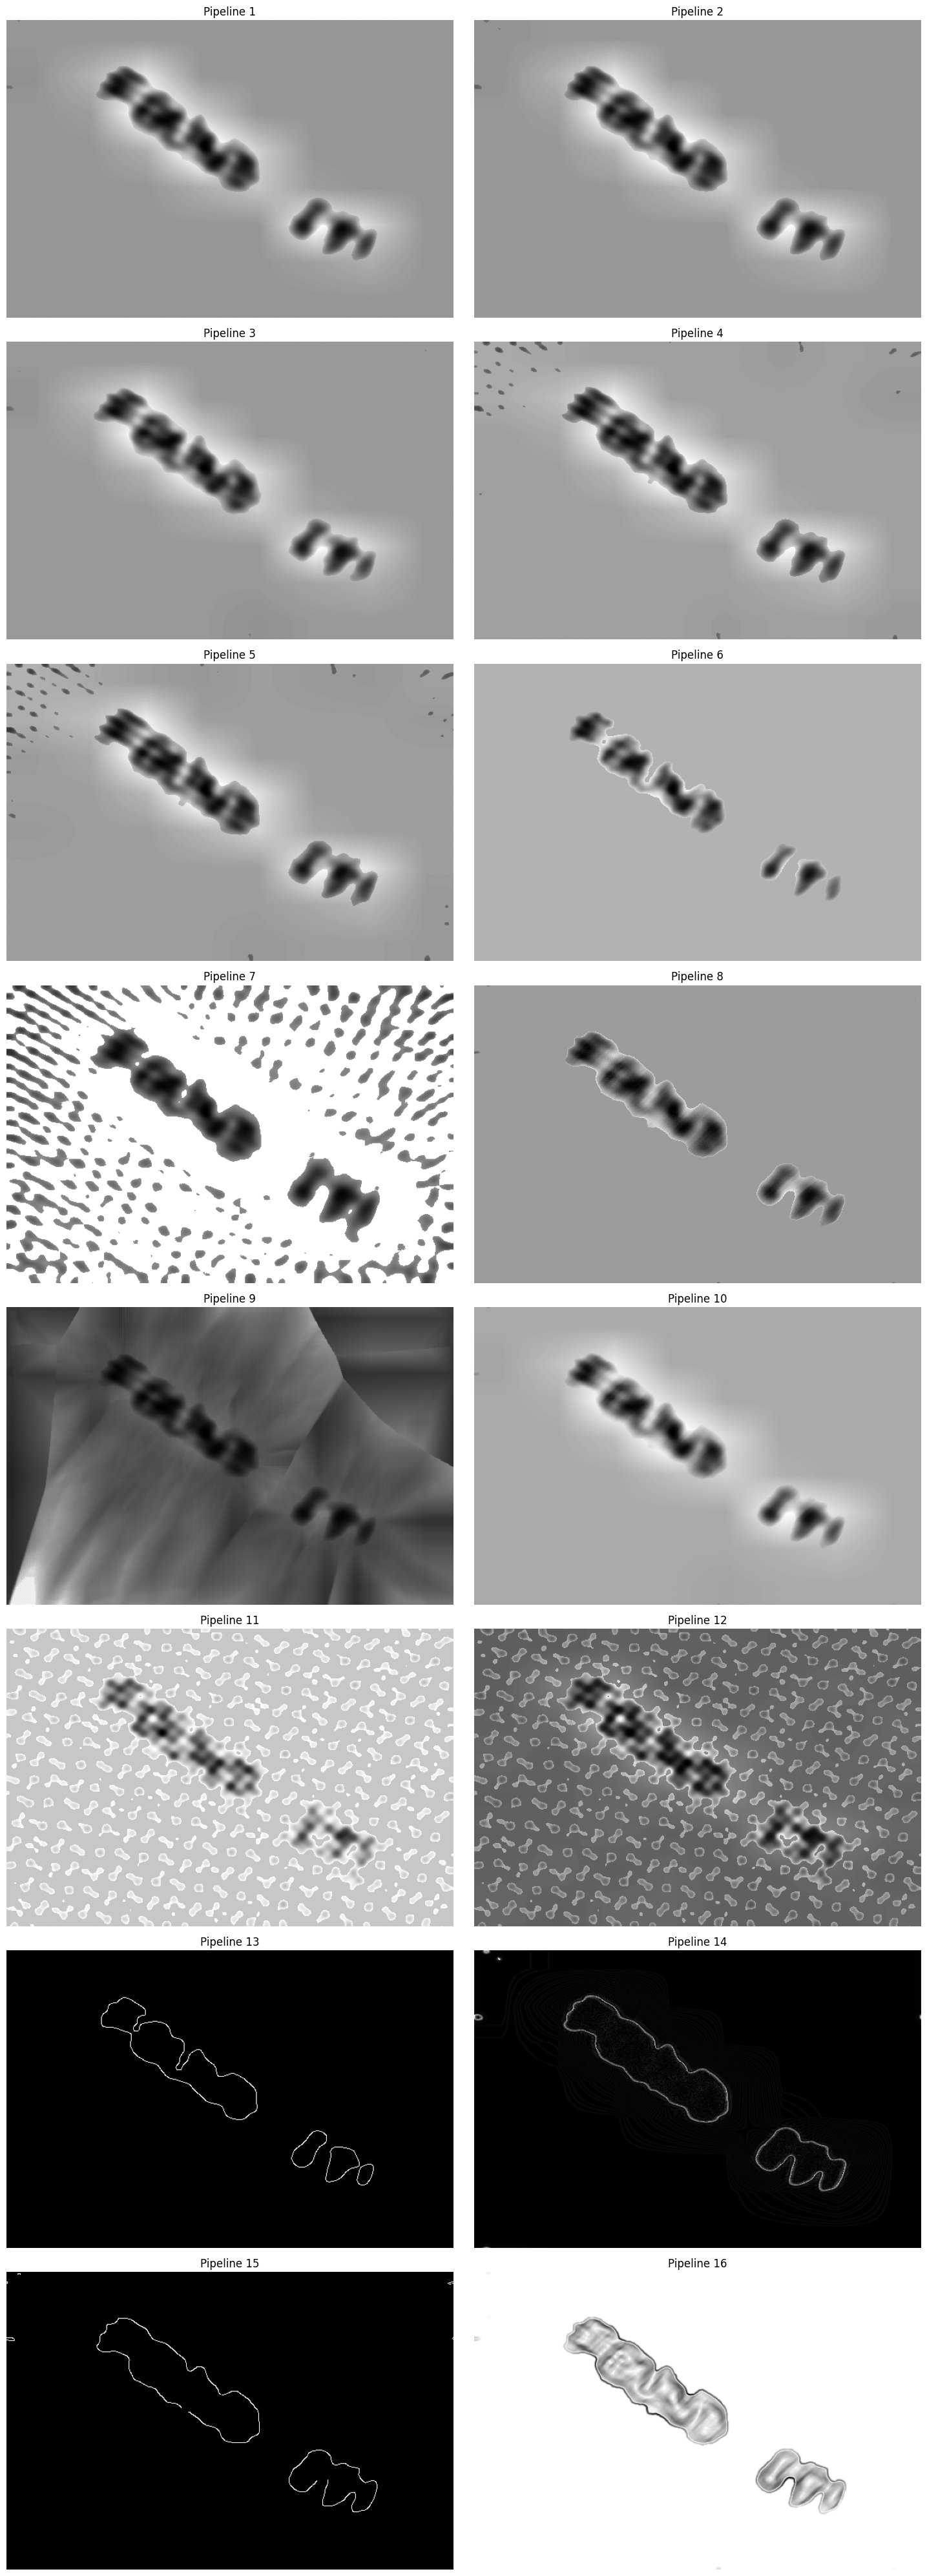

In [982]:
pipelines = [

    ["median", "dft", "notch0", "low_pass", "idft", "bilateral", "thresholding_inpaint", "paint", "clahe", "gamma"],
    ["inpaint", "dft", "notch0", "low_pass", "idft", "bilateral", "thresholding_inpaint", "paint", "clahe", "gamma"],
    ["gaussian", "dft", "notch0", "low_pass", "idft", "bilateral", "thresholding_inpaint", "paint", "clahe", "gamma"],
    ["median", "dft", "notch0", "inversed_notch", "idft", "bilateral", "thresholding_inpaint", "paint", "clahe", "gamma"],
    ["inpaint", "dft", "notch0", "inversed_notch", "idft", "bilateral", "thresholding_inpaint", "paint", "clahe", "gamma"],
    ["inpaint", "dft", "notch1", "low_pass", "idft", "bilateral", "thresholding_inpaint", "dft", "notch2", "inversed_notch", "idft", "thresholding_inpaint", "clahe", "paint"],
    ["inpaint", "dft", "notch0", "low_pass", "idft", "bilateral", "clahe", "thresholding_inpaint", "gamma", "paint"],
    ["inpaint", "dft", "notch1", "low_pass", "idft", "bilateral", "dft", "notch2", "idft", "thresholding_inpaint", "sharpen", "clahe", "paint"],
    ["inpaint", "bilateral", "dft", "low_pass", "notch0", "idft", "gaussian", "thresholding_inpaint", "clahe", "gamma"],
    ["inpaint", "dft", "notch1", "low_pass", "inversed_notch", "idft", "bilateral", "dft", "notch2", "idft", "thresholding_inpaint", "paint", "clahe"],
    ["inpaint", "dft", "low_pass", "idft", "bilateral", "thresholding_inpaint", "paint"],
    ["inpaint", "dft", "low_pass", "idft", "bilateral", "thresholding_inpaint", "paint", "clahe", "gamma"],
    ["median","dft", "notch0", "low_pass","idft", "bilateral", "thresholding_inpaint","paint" , "invert", "binarize", "canny"],
    ["inpaint","dft", "notch0", "low_pass","idft", "bilateral", "thresholding_inpaint","paint" , "clahe","gamma","dft","high_pass","idft"],
    ["inpaint", "bilateral", "dft", "low_pass", "notch0", "idft", "gaussian", "thresholding_inpaint", "clahe", "gamma","invert","paint","canny"],
    ["inpaint", "dft", "notch1", "low_pass", "inversed_notch", "idft", "bilateral", "dft", "notch2", "idft", "thresholding_inpaint", "paint", "clahe","invert","paint","sobel","invert"],

]

results = []

for pipe in pipelines:
    masks.clear()
    results.append(run_pipeline(data, pipe, False, False))
    
print("All pipelines completed!")
# Display all results in a 2-column grid
rows = (len(pipelines) + 1) // 2  # Calculate needed rows for 2 columns
fig, axes = plt.subplots(rows, 2, figsize=(15, 5*rows))
axes = axes.ravel()  # Flatten axes array for easier indexing

for i, result in enumerate(results):
    axes[i].imshow(result, cmap='gray')
    axes[i].set_title(f"Pipeline {i+1}")
    axes[i].axis('off')

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Readability

Overall, we believe this pipeline works well in improving the clarity of the word. While we didn’t achieve a perfect denoise of the image, the pipeline significantly enhances our understanding of the text. It starts with the median filter to remove salt-and-pepper noise, providing an immediate reduction in noise. The bilateral filter is then applied to preserve edges while further smoothing out the image and reducing noise.

Next, the DFT (Discrete Fourier Transform) is used to analyze the frequency components of the image, followed by notch0 filtering to eliminate unwanted frequencies. The low-pass filter smooths the image, removing high-frequency noise. Afterward, we use IDFT (Inverse DFT) to transform the image back to the spatial domain.

To enhance the text's structure, thresholding and inpainting are applied, filling in missing details and sharpening the contours. The paint step restores any unclear regions, while CLAHE (Contrast Limited Adaptive Histogram Equalization) boosts local contrast for better text legibility. Finally, gamma correction adjusts the overall brightness and contrast, ensuring the text is clearer.

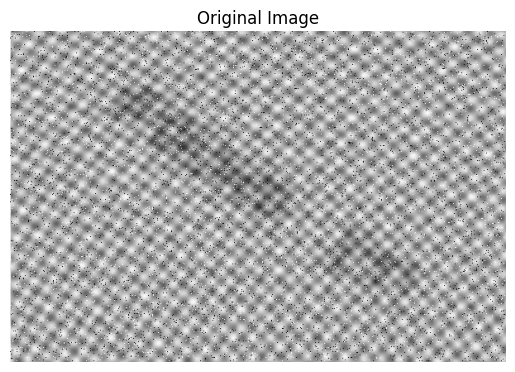

Step: median
Data type: float32


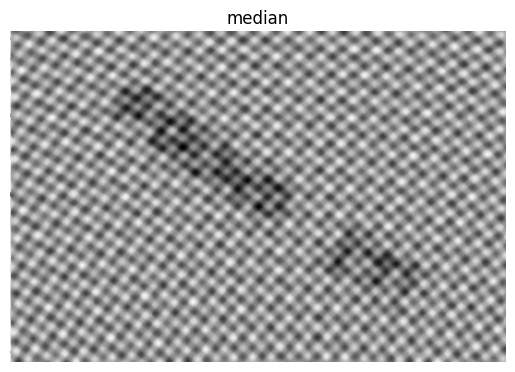

Step: bilateral
Data type: float32


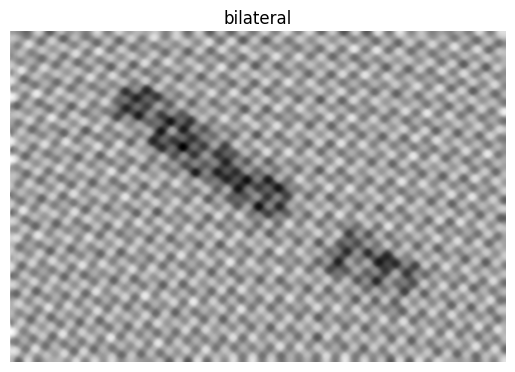

Step: dft
Data type: float32


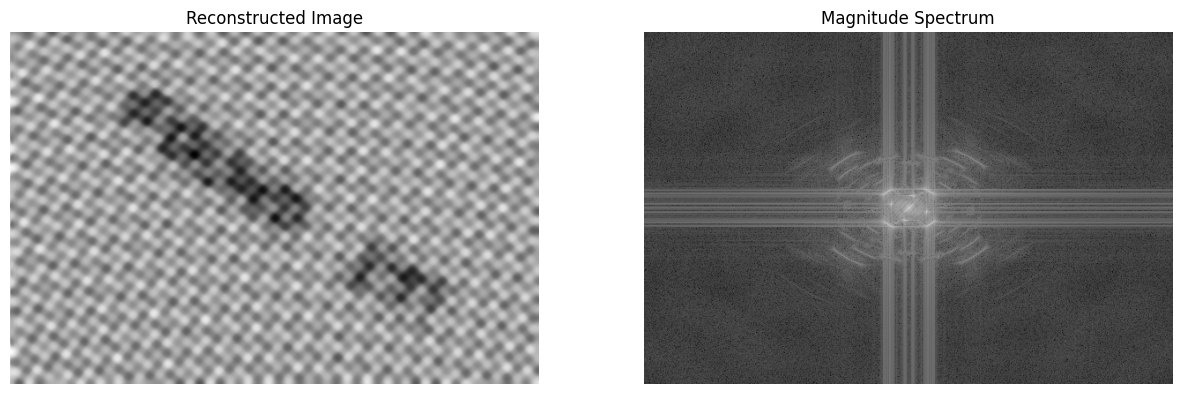

Step: notch0
Data type: float32


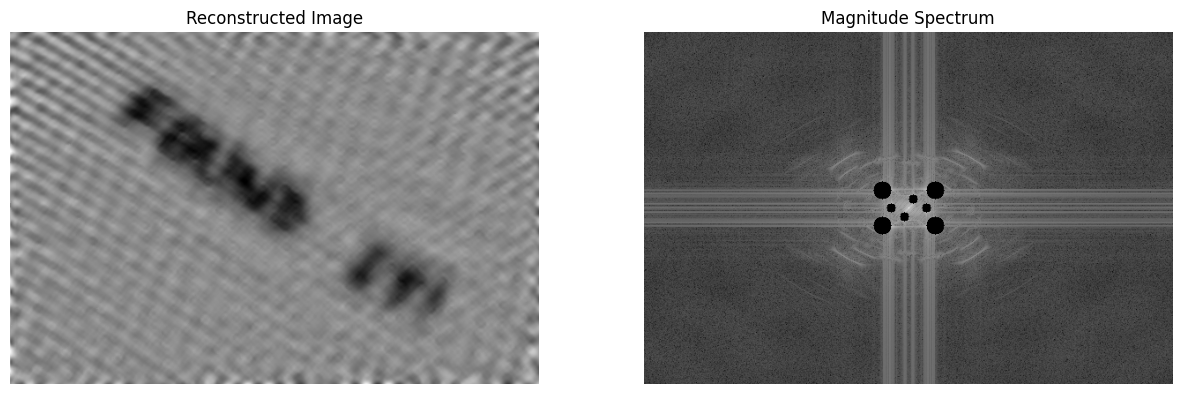

Step: low_pass
Data type: float32


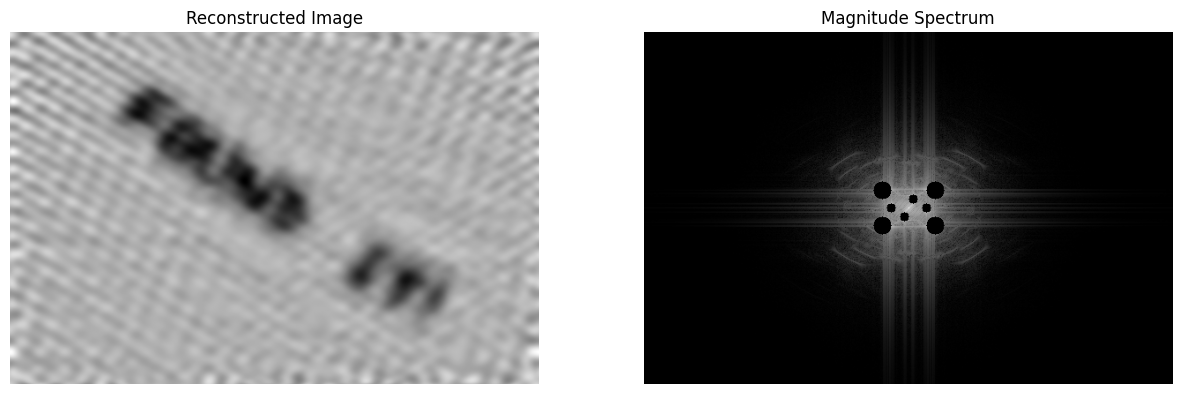

Step: idft
Data type: uint8


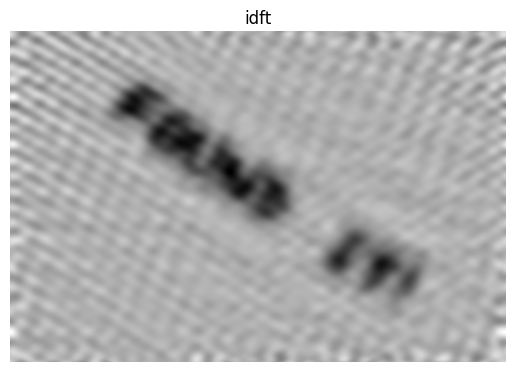

Step: thresholding_inpaint
Data type: uint8


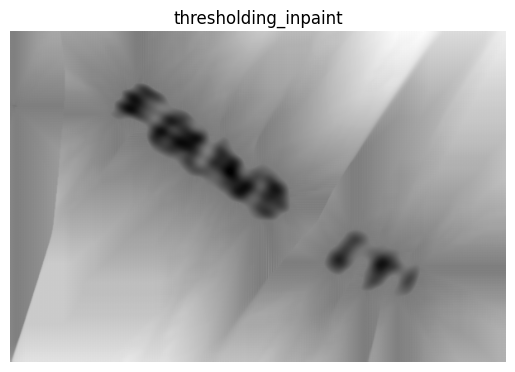

Step: paint
Data type: uint8


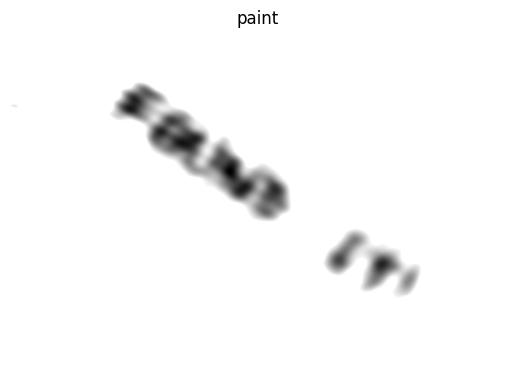

Step: clahe
Data type: uint8


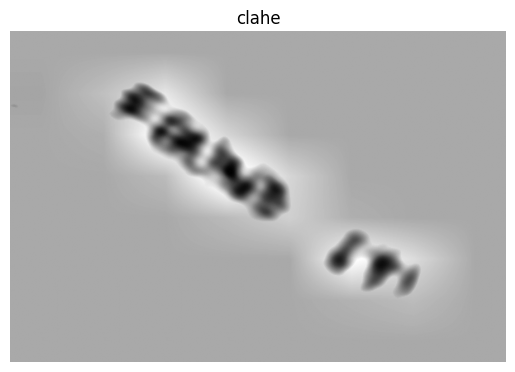

Step: gamma
Data type: uint8


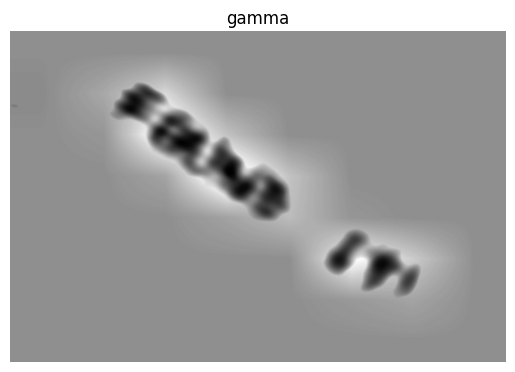

Step: paint
Data type: uint8


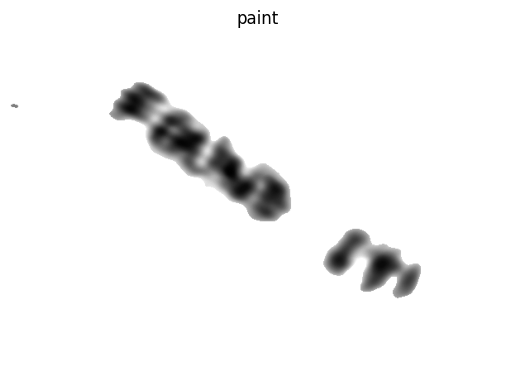

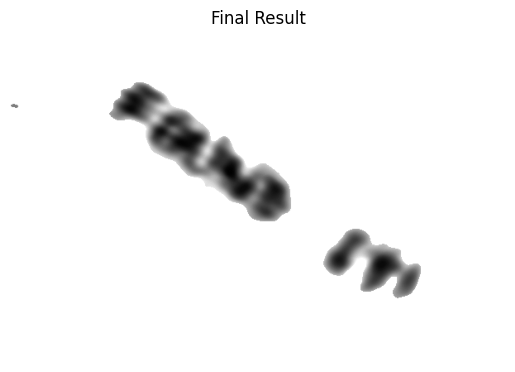

Pipeline completed!


In [990]:
pipeline_order = ["median", "bilateral", "dft", "notch0", "low_pass", "idft", "thresholding_inpaint", "paint", "clahe", "gamma","paint"]
result = run_pipeline(data, pipeline_order, debug=True, finished=True)

# Save the final result
cv2.imwrite('results/readability.png', result)

data = original.copy()

### Edges

Overall, we believe this pipeline performs better in capturing the edges of the words. Although most letters are interconnected, it doesn’t provide a word-by-word contour. However, it allows us to capture excellent detail in individual letters, such as the "U," successfully achieving the desired dip.

The pipeline starts with the median filter, which reduces salt-and-pepper noise, improving the overall clarity of the image. The bilateral filter is then applied to smooth the image while preserving important edges. Next, the DFT (Discrete Fourier Transform) analyzes the frequency components of the image, followed by notch0 filtering to remove unwanted frequencies. The low-pass filter smooths the image further by removing high-frequency noise, and IDFT (Inverse DFT) transforms the image back to the spatial domain.

Afterward, thresholding and inpainting are used to fill in missing details and enhance the structure of the letters. The paint step restores any unclear regions, and the invert function adjusts the image’s contrast for better clarity. The binarize step converts the image to a binary format, simplifying the edges. Finally, the Sobel filter is applied to detect the edges more effectively, enhancing the contours of the letters and making the text more defined.

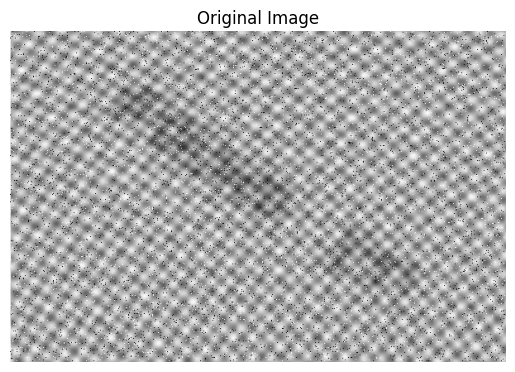

Step: median
Data type: float32


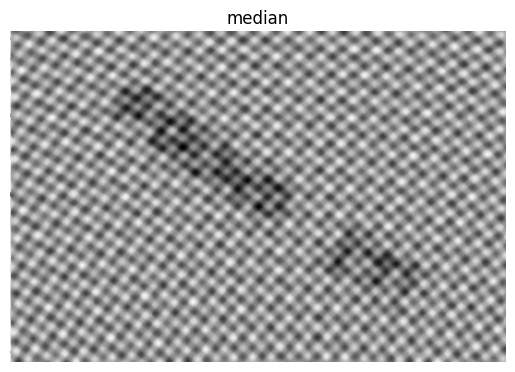

Step: bilateral
Data type: float32


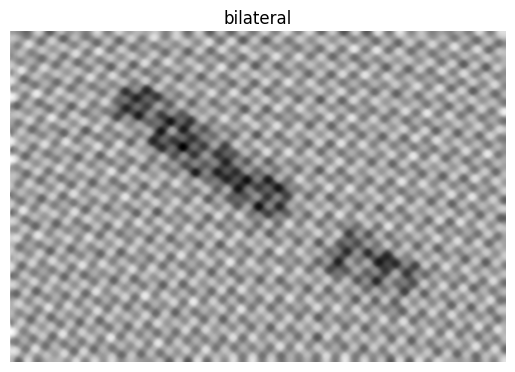

Step: dft
Data type: float32


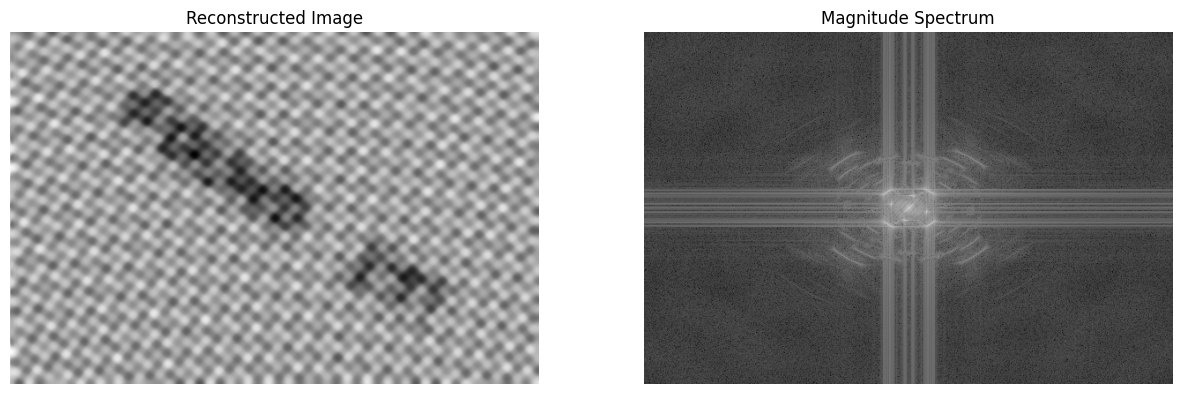

Step: notch1
Data type: float32


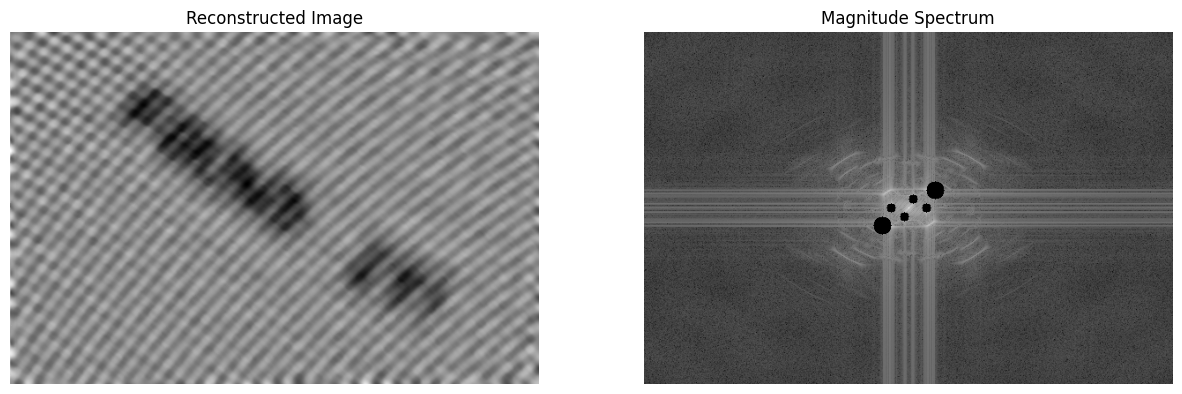

Step: low_pass
Data type: float32


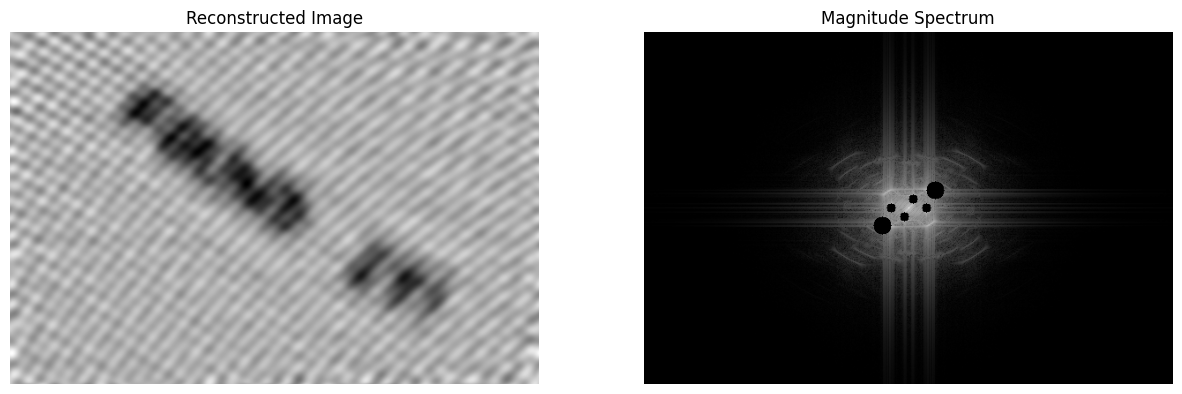

Step: notch2
Data type: float32


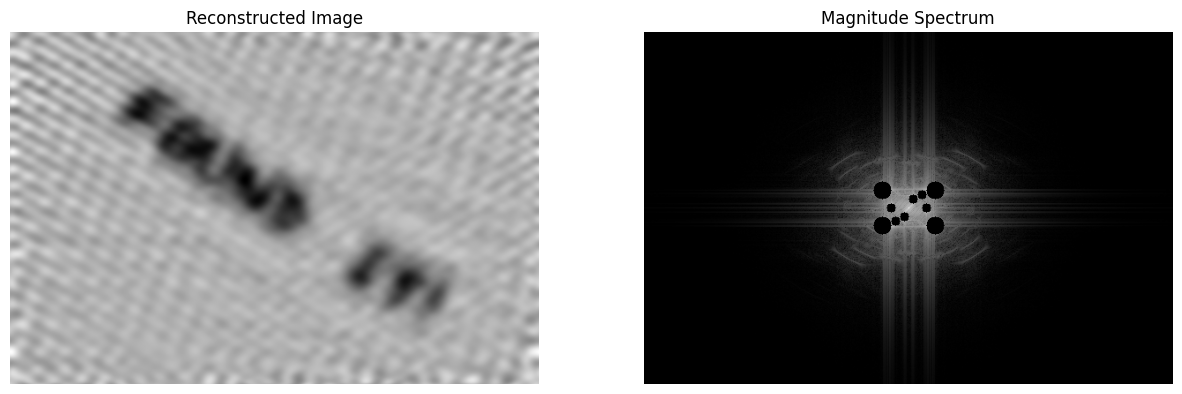

Step: idft
Data type: uint8


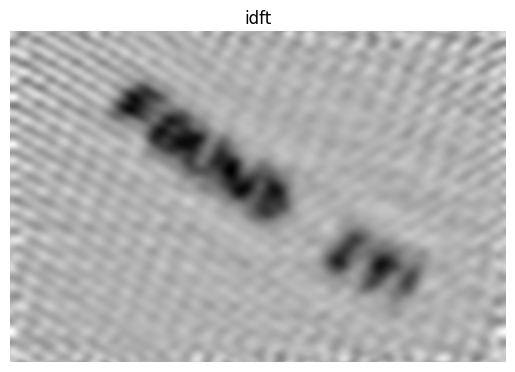

Step: thresholding_inpaint
Data type: uint8


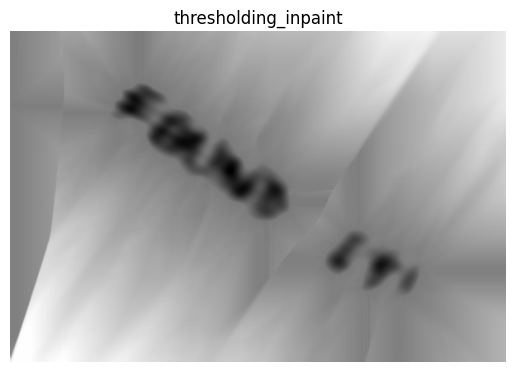

Step: paint
Data type: uint8


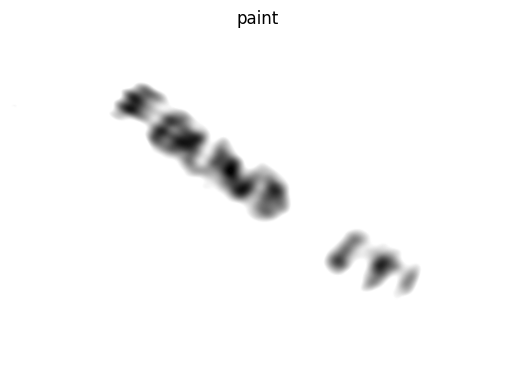

Step: invert
Data type: uint8


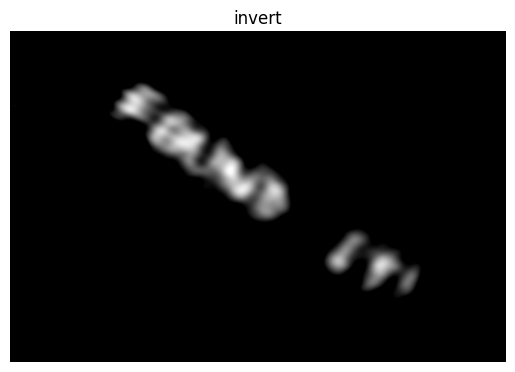

Step: binarize
Data type: uint8


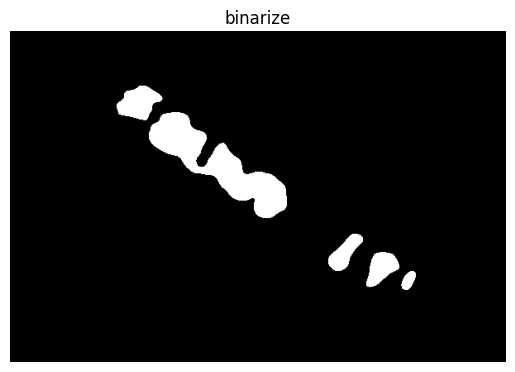

Step: sobel
Data type: uint8


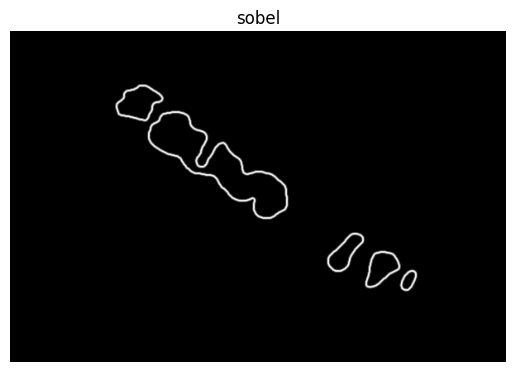

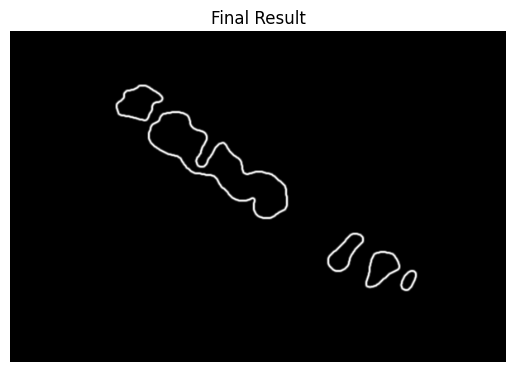

Pipeline completed!


In [ ]:
# pipeline_order = ["median","bilateral","dft", "notch0", "inversed_notch","idft", "thresholding_inpaint","paint", "clahe", "invert", "binarize", "canny"] 
# #for this pipeline to work i must change the threshold in binariztion to 127

pipeline_order = ["median", "bilateral","dft", "notch0", "low_pass","idft",  "thresholding_inpaint","paint" , "invert", "binarize", "sobel"]

data = run_pipeline(data, pipeline_order, debug=True, finished=True)

# Save the final result
cv2.imwrite('results/edges.png', data)

data = original.copy()
